<a href="https://colab.research.google.com/github/howsmyanimeprofilepicture/image-tokenizer-for-mbrl/blob/main/ImageTokenizerForMBRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download Dataset
!wget https://github.com/howsmyanimeprofilepicture/image-tokenizer-for-mbrl/raw/main/traj.tar.xz
!tar xf traj.tar.xz  

--2023-05-25 15:31:44--  https://github.com/howsmyanimeprofilepicture/image-tokenizer-for-mbrl/raw/main/traj.tar.xz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/howsmyanimeprofilepicture/image-tokenizer-for-mbrl/main/traj.tar.xz [following]
--2023-05-25 15:31:44--  https://raw.githubusercontent.com/howsmyanimeprofilepicture/image-tokenizer-for-mbrl/main/traj.tar.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8715324 (8.3M) [application/octet-stream]
Saving to: ‘traj.tar.xz’

traj.tar.xz         100%[===================>]   8.31M  --.-KB/s    in 0.02s   

2023-05-25 15:31:45 (345 MB/s)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from typing import NamedTuple, List
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import random


In [ ]:
#@title `utils.py`


class TrajSpan(NamedTuple):
    obs: List[np.ndarray]
    action: List[int]
    reward: List[float]
    done: List[bool]


class Trajectory:
    """Trajectory class to collect offline dataset"""

    @staticmethod
    def from_pickle(file_path):
        """Args
        - file_path(str): the path of pickle file
        """
        with open(file_path, "rb") as f:
            traj: Trajectory = pickle.load(f)
        return traj

    def __init__(self) -> None:

        self.obs: List[np.ndarray] = []
        self.action: List[int] = []
        self.reward: List[float] = []
        self.done: List[bool] = []

    def __getitem__(self, key):
        if type(key) == int:
            key = slice(key, key+1)
        return TrajSpan(self.obs[key],
                        self.action[key],
                        self.reward[key],
                        self.done[key])

    def add(self, obs, action, reward, done):
        self.obs.append(obs)
        self.action.append(action)
        self.reward.append(reward)
        self.done.append(done)


In [ ]:
#@title `blocks.py`

class ResBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 mid_channels=None,
                 batch_norm=False):
        super(ResBlock, self).__init__()

        if mid_channels is None:
            mid_channels = out_channels

        layers = [
            nn.ReLU(),
            nn.Conv2d(in_channels, mid_channels,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(mid_channels, out_channels,
                      kernel_size=1, stride=1, padding=0)
        ]
        if batch_norm:
            layers.insert(2, nn.BatchNorm2d(out_channels))
        self.convs = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.convs(x)


class Quantizer(nn.Module):
    """Quantize embedding vectors"""

    def __init__(self, num_embeddings,
                 embedding_dim) -> None:
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.emb_table = nn.Embedding(num_embeddings,
                                      embedding_dim)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        b_size, emb_dim, h, w = z.size()
        z = z.reshape(b_size,
                      emb_dim,
                      h*w)
        z = z.permute(0, 2, 1)
        z = z.reshape(b_size*h*w,
                      emb_dim)
        z = z.unsqueeze(1)
        z = z.expand(b_size*h*w,
                     self.num_embeddings,
                     emb_dim)
        W = self.emb_table.weight.detach()
        assert W.size() == (self.num_embeddings,
                            emb_dim)
        W = W.unsqueeze(0)
        W = W.expand(b_size*h*w,
                     self.num_embeddings,
                     emb_dim)
        token_ids = torch.argmin(((z - W)**2).mean(dim=-1),
                                 dim=-1)
        assert token_ids.ndim == 1
        token_ids = token_ids.reshape(b_size, h*w)
        quantized_embs = self.emb_table(token_ids)
        assert quantized_embs.size() == (b_size, h*w, emb_dim)
        quantized_embs = quantized_embs.permute(0, 2, 1)
        return quantized_embs.reshape(b_size, emb_dim, h, w)


class AttentionBlock(nn.Module):
    """
    This block is NOT MULTIHEAD!
    - https://github.com/CompVis/taming-transformers/blob/master/taming/modules/diffusionmodules/model.py#L140-L192
    - https://github.com/eloialonso/iris/blob/main/src/models/tokenizer/nets.py#LL311C1-L331C44"""

    def __init__(self, emb_dim) -> None:
        super().__init__()
        self.qkv_proj = nn.Conv2d(emb_dim,
                                  3 * emb_dim,
                                  kernel_size=1,
                                  stride=1,
                                  padding=0)
        self.out_proj = nn.Conv2d(emb_dim,
                                  emb_dim,
                                  kernel_size=1,
                                  stride=1,
                                  padding=0)

    def forward(self, x):
        b_size, emb_dim, h, w = x.size()
        qkv = self.qkv_proj.forward(x)
        assert qkv.size() == (b_size, emb_dim*3, h, w)
        qkv = qkv.reshape(b_size, emb_dim*3, h*w)
        qkv = qkv.permute(0, 2, 1)
        q, k, v = qkv.split(emb_dim, dim=-1)
        assert q.size() == (b_size, h*w, emb_dim)
        attn_matrix = torch.matmul(q,
                                   k.permute(0, 2, 1))

        assert attn_matrix.size() == (b_size, h*w, h*w)
        attn_score = F.softmax(attn_matrix / emb_dim**0.5,
                               dim=-1)

        attn_output = attn_score@v
        assert attn_output.size() == (b_size, h*w, emb_dim)
        attn_output = attn_output.permute(0, 2, 1)
        attn_output = attn_output.reshape(b_size, emb_dim, h, w)
        return x + self.out_proj(attn_output)


In [ ]:
#@title vqvae.py

class VQVAEResult(NamedTuple):
    x_hat: torch.Tensor
    recon_loss: torch.Tensor
    commit_loss: torch.Tensor
    vq_loss: torch.Tensor


class VQVAE(nn.Module):
    """ Discrete AutoEncoder to tokenize Image Tensors.
    - source: https://github.com/nadavbh12/VQ-VAE/blob/master/vq_vae/auto_encoder.py#L277
    """

    def __init__(self, emb_dim=512, num_embs=200) -> None:
        super().__init__()
        self.quantizer = Quantizer(num_embs,
                                   emb_dim)

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=emb_dim,
                      kernel_size=4,
                      stride=2,
                      padding=1),
            nn.BatchNorm2d(emb_dim),
            nn.ReLU(),
            nn.Conv2d(emb_dim,
                      emb_dim,
                      kernel_size=4,
                      stride=2,
                      padding=1),
            nn.BatchNorm2d(emb_dim),
            nn.ReLU(),
            ResBlock(emb_dim, emb_dim, batch_norm=True),
            nn.BatchNorm2d(emb_dim),
            ResBlock(emb_dim, emb_dim, batch_norm=True),
            nn.BatchNorm2d(emb_dim),
        )

        self.decoder = nn.Sequential(
            ResBlock(emb_dim, emb_dim),
            nn.BatchNorm2d(emb_dim),
            ResBlock(emb_dim, emb_dim),
            nn.ConvTranspose2d(
                emb_dim, emb_dim,
                kernel_size=4,
                stride=2,
                padding=1),
            nn.BatchNorm2d(emb_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(
                emb_dim, 3,
                kernel_size=4,
                stride=2,
                padding=1
            ),
        )

    def forward(self, x: torch.Tensor) -> VQVAEResult:
        z = self.encoder(x)
        z_quantized = self.quantizer(z)
        x_hat = self.decoder(z_quantized)

        recon_loss = ((x_hat-x)**2).mean()
        commit_loss = ((z.detach()
                       - z_quantized)**2).mean()
        vq_loss = ((z-z_quantized.detach())**2).mean()
        return VQVAEResult(x_hat,
                           recon_loss,
                           commit_loss,
                           vq_loss)

    @torch.no_grad()
    def tokenize(self, x: torch.Tensor) -> torch.Tensor:
        z = self.encoder(x)
        z_quantized = self.quantizer(z)
        return z_quantized

    @torch.no_grad()
    def viz_recon(self,
                  x: torch.Tensor):
        """Visualizing the reconstructed result 
        to evaluate 
        how well the model reconstructs the original input"""
        assert x.ndim == 3
        assert x.shape[0] == 3
        x = x.unsqueeze(0)
        x_hat = self.forward(x).x_hat

        x_hat = x_hat.detach().cpu()[0].permute(1, 2, 0)
        fig, (ax1, ax2) = plt.subplots(2)
        ax1.imshow(x[0].permute(1, 2, 0).cpu())
        ax2.imshow(x_hat)
        plt.show()


In [ ]:
 # args
emb_dim = 64
vocab_size = 1000
lr = 0.005
batch_size = 64
epoch = 50
device = ("cuda"
            if torch.cuda.is_available()
            else "cpu")

In [ ]:
vqvae = VQVAE(emb_dim,
                num_embs=vocab_size,
                ).to(device=device)
trajectories = Trajectory.from_pickle("./traj.pkl")
NUM_TOTAL_DATA = len(trajectories.obs)
optimzer = torch.optim.Adam(vqvae.parameters(),
                            lr=lr)

6.01578
11.28153
11.28153
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.95954
1.18450
1.18450
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.66314
0.72939
0.72939
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.57749
0.61352
0.61352
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


0.50257
0.55360
0.55360
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


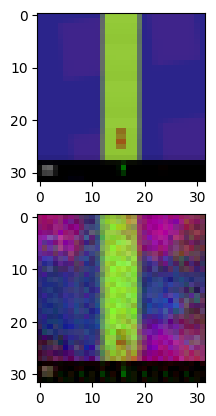

0.43135
0.49117
0.49117
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.39203
0.35248
0.35248
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.37992
0.37709
0.37709
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.37423
0.31385
0.31385
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


0.32150
0.27148
0.27148
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


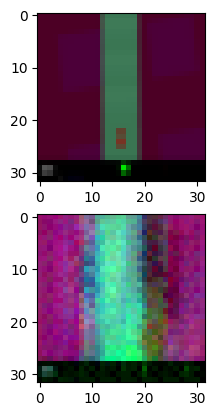

0.32344
0.24133
0.24133
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.31750
0.20252
0.20252
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.30593
0.18674
0.18674
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.28860
0.17580
0.17580
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


0.27358
0.13410
0.13410
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


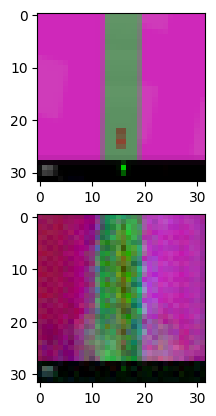

0.26999
0.12517
0.12517
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.30513
0.13036
0.13036
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.29048
0.10788
0.10788
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.28734
0.09122
0.09122
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


0.27123
0.08354
0.08354
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


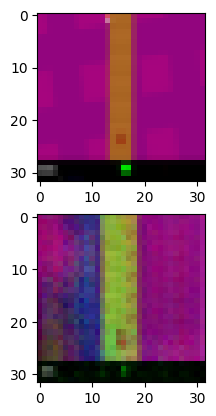

0.27556
0.07835
0.07835
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.26603
0.06886
0.06886
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.26940
0.06440
0.06440
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.26130
0.06015
0.06015
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


0.25587
0.05963
0.05963
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


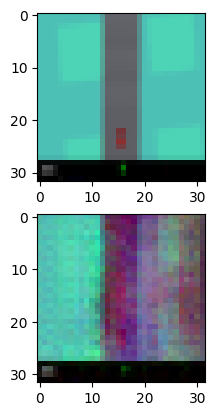

0.25586
0.04941
0.04941
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.25239
0.04801
0.04801
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.25395
0.04800
0.04800
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.24549
0.04012
0.04012
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


0.24931
0.04128
0.04128
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


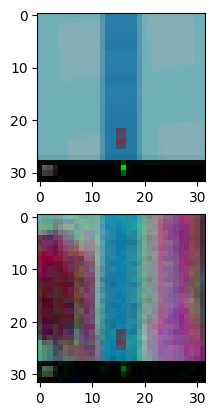

0.24476
0.03777
0.03777
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.24490
0.03358
0.03358
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.25613
0.03241
0.03241
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.24583
0.03219
0.03219
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


0.25094
0.03373
0.03373
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


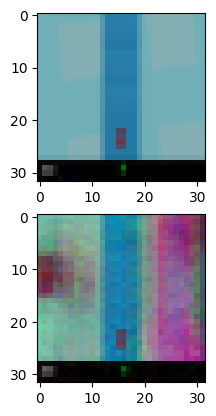

0.23598
0.02813
0.02813
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.22992
0.02665
0.02665
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.23205
0.02642
0.02642
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.23035
0.02405
0.02405
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


0.23058
0.02576
0.02576
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


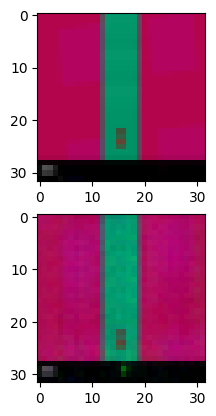

0.23652
0.02432
0.02432
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.23978
0.02659
0.02659
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.23523
0.02477
0.02477
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.22806
0.02312
0.02312
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


0.23411
0.02257
0.02257
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


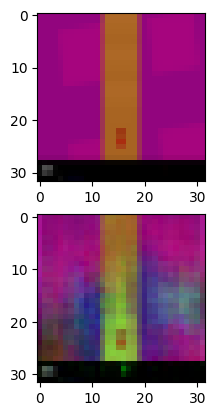

0.23281
0.02370
0.02370
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.24043
0.02062
0.02062
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.23239
0.02883
0.02883
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
0.22376
0.01837
0.01837
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


0.22960
0.01681
0.01681
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


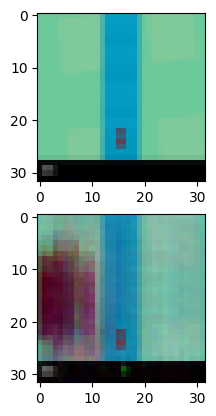

In [ ]:
for j in range(epoch):
        observations = random.sample(trajectories.obs,
                                     NUM_TOTAL_DATA)
        observations = np.stack(observations)
        observations = torch.tensor(observations,
                                    dtype=torch.float32)
        observations = observations.permute(0, 3, 1, 2)  # (N, C, H, W)
        vq_losses = 0
        recon_losses = 0
        commit_losses = 0
        for i in range(0,
                       len(observations),
                       batch_size):

            obs = observations[i: i + batch_size]
            obs = obs.to(device=device)
            res = vqvae(obs)
            loss = (res.vq_loss
                    + 1.5*res.recon_loss
                    + 0.4*res.commit_loss)
            vq_losses += res.vq_loss.item()
            recon_losses += res.recon_loss.item()
            commit_losses += res.commit_loss.item()
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
        print(f"{recon_losses:.5f}")
        print(f"{commit_losses:.5f}")
        print(f"{vq_losses:.5f}")
        print("=-"*25)
        if j % 5 == 4:
            vqvae.viz_recon(obs[0])
            torch.save(vqvae, f"./epoch_{j}.chpt")